In [8]:
import os, re
import pandas
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize, ConvertImageDtype, Normalize
import torchvision.transforms.functional as F

from torch.optim import lr_scheduler
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, models, transforms
import time
import os
from tempfile import TemporaryDirectory
import numpy as np

root_dir        = '/home/paula/Data/paula' # directorio raíz
dataset_name     = 'MURA-v1.1' 
study_type       = 'XR_WRIST'
train = False
annotation_files   = {'train':'train_labeled.csv', 'test':'valid_labeled.csv'}
data_split_folders = {'train': 'train', 'test':'valid'}

In [9]:
# Defnición de clase MuraDataset para poner en un módulo que se importará
# El módulo es un fichero .py (por ejemplo muradataset.py) accesible (para simplificar, en misma carpeta)

import os
import pandas as pd
from torch.utils.data import Dataset
from torchvision.io import read_image, ImageReadMode

class MuraDataset(Dataset):
    # La clase hereda de torch,utils.data.Dataset
    # Los datasets en pytorch deben tener Dataset como ancestro

    # Variables de clase, comunes para todos los objetos de la misma
    dataset_name       = 'MURA-v1.1' 
    annotation_files   = {'train':'train_labeled.csv', 'test':'valid_labeled.csv'}
    data_split_folders = {'train': 'train', 'test':'valid'}
    labels_map         = {0: 'negativo', 1:'positivo'}

    # Método de inicialización de los objetos de la clase. Sobreescribe al de Dataset
    def __init__(self, root_dir, study_type='XR_WRIST', train=True, rgb=True, transform=None, target_transform=None):

        self.root_dir = root_dir
        self.train = train
        self.rgb = rgb
        #self.img_dir = os.path.normpath(
        #    (os.path.join(root_dir, dataset_name, data_split_folders['train'], study_type) if train 
        #                else os.path.join(root_dir, dataset_name, data_split_folders['test'], study_type)))

        self.annotations_file =  os.path.normpath(
            (os.path.join(root_dir, dataset_name, annotation_files['train']) if train else 
                                  os.path.join(root_dir, dataset_name, annotation_files['test'])))
        all_img_labels  = pd.read_csv(self.annotations_file) # Se carga el fichero con todos los estudios
        # Se selecciona el tipo de estudio. EL data frame tiene la ruta a cada imagen y su etiqueta
        self.img_labels = all_img_labels if study_type=='ALL' \
            else all_img_labels.iloc[(all_img_labels['Path'].str.contains(study_type)).to_numpy()].copy()
        
        self.transform = transform
        self.target_transform = target_transform
    
    # Método de longitud del dataset. Sobreescribe al de Dataset
    def __len__(self):
        return len(self.img_labels)

    # Método para obtener una única imagen y su etiqueta correspondiente 
    def __getitem__(self, idx):
        # Ruta al fichero con la imagen
        img_path = os.path.join(self.root_dir, self.img_labels.iloc[idx, 0])
        
        im_mode= ImageReadMode.RGB if self.rgb else ImageReadMode.GRAY 
        image = read_image(img_path, mode=im_mode)
        
        # Se obtiene la etiqueta correspondiente
        label = self.img_labels.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [10]:
# Comprobamos que pueden leerse las imágenes en gris y en RGB
# en Pytorch las bandas son C (color),H (altura),W (anchura)
# Mientras que normalmente es H, W, C. Hay que tenerlo en cuenta para visualizar  
img_data = MuraDataset(root_dir, study_type='ALL', rgb=False)
sample_idx = torch.randint(len(img_data), size=(1,)).item()
img, label = img_data[sample_idx]

print(img.shape, '\t', img.dtype)
print('Pixel arbitrario:\t', img[:,10,150])

torch.Size([1, 512, 252]) 	 torch.uint8
Pixel arbitrario:	 tensor([43], dtype=torch.uint8)


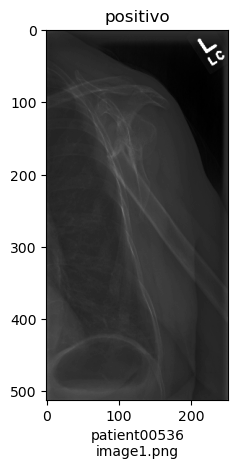

In [11]:
# Convertimos imagen de tensores a imagen PIL para representarla
plt.imshow(F.to_pil_image(img), cmap='gray')
patient = re.search(r'\bpatient\d+\b', img_data.img_labels.iloc[sample_idx,0]).group()

plt.xlabel(patient+'\n'+ os.path.basename(img_data.img_labels.iloc[sample_idx,0]))
plt.title(img_data.labels_map[label])
plt.show()

In [12]:
# Explícitamente pedimos que se lea como RGB, pues estaba puesto como gris
img_data.rgb=True
img, label = img_data[sample_idx]

print(img.shape, '\t', img.dtype)
print('Pixel arbitrario:\t', img[:,10,150])

torch.Size([3, 512, 252]) 	 torch.uint8
Pixel arbitrario:	 tensor([43, 43, 43], dtype=torch.uint8)


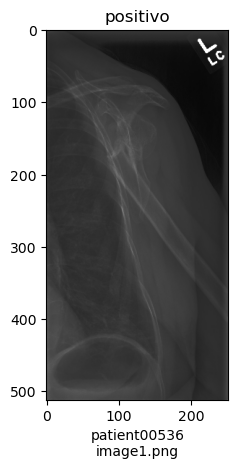

In [13]:
# Convertimos imagen de tensores a imagen PIL para representarla
plt.imshow(F.to_pil_image(img), cmap='gray')

patient = re.search(r'\bpatient\d+\b', img_data.img_labels.iloc[sample_idx,0]).group()
plt.xlabel(patient+'\n'+ os.path.basename(img_data.img_labels.iloc[sample_idx,0]))
plt.title(img_data.labels_map[label])
plt.show()

In [14]:
# Estadísticos (máximo y mínimo) del repositorio
# con TODAS las imágenes de entrenamiento
# max = 255 min =0 - tarda 4 minutos en CPU
img_data.rgb=False

max, min = 0, 0
for i in range(len(img_data)):
    img, _ = img_data[i]

    aux = torch.max(img)
    max = aux if aux > max else max
    
    aux = torch.min(img)
    min = aux if aux < min else min


print('Mínimo: ', min, '\tMáximo: ', max)

Mínimo:  0 	Máximo:  tensor(255, dtype=torch.uint8)


In [15]:
# Número total de píxeles y suma total para calcular media muestral
# Tarda dos minutos y medio en CPU

media  = 0
n_pxls = 0
for i in range(len(img_data)):
    img, _ = img_data[i]

    media = media + torch.sum(img)
    n_pxls = n_pxls + img.shape[0]*img.shape[1]*img.shape[2]
    
print('Número de píxeles: ', n_pxls, '\tSuma total: ', media.item(), '\tMedia: ', (media/n_pxls).item())

Número de píxeles:  7130201600 	Suma total:  375043758839 	Media:  52.59931945800781


In [9]:
print('Número de píxeles: ', n_pxls, '\tSuma total: ', media.item(), '\tMedia: ', (media/n_pxls).item())

Número de píxeles:  7130201600 	Suma total:  375043758839 	Media:  52.59931945800781


In [10]:
# Varianza muestral
# Tarda dos minutos y 50 segs en CPU

var  = 0
for i in range(len(img_data)):
    img, _ = img_data[i]

    var = var + torch.sum(torch.pow(img-media, 2))
    
    
print('Varianza muestral: ', (var/(n_pxls-1)).item(), 'Desviación típica muestral: ', torch.pow(var/(n_pxls-1), 0.5).item())

Varianza muestral:  114.23052215576172 Desviación típica muestral:  10.687868118286133


In [11]:
media = (media/n_pxls).item()
sigma = torch.pow(var/(n_pxls-1), 0.5).item()

print('Media (0-255): ', media, '\tDesviación típica (0-255): ', sigma)
print('Media (0-1): ', media/255, '\tDesviación típica (0-1): ', sigma/255)

Media (0-255):  52.59931945800781 	Desviación típica (0-255):  10.687868118286133
Media (0-1):  0.20627184101179535 	Desviación típica (0-1):  0.04191320830700444


In [16]:
# La clase Dataset permite transformar las imágenes, para
# adecuarlas a la cadena posterior de procesado
# En el caso de DenseNet, podemos tomar de referencia
# https://pytorch.org/hub/pytorch_vision_densenet/
# La red espera imágenes RGB 

transform = Compose([
    # Se ajustan las dimensiones de la imagen al tamaño que espera la red neuronal
    Resize(size=(224,224)),
    # Las imágenes se convierten a punto flotante (eran enteras) 
    ConvertImageDtype(torch.float),
    # Se normalizan las imágenes, para que resulten con media cero y sigma=1
    # Suelen utilizarse los valores de los canals RGB de ImageNet
    # aunque esto no es realmente consistente. En particular si la imagen es
    # gris con tres canales, al normalizar resultarán canales con valores diferentes
    # y se verán en color. Los píxeles pueden tener valores negativos
    #Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
     # Pueden usuarse alternativamente los valores de media y de sigma 
     # obtenidos para el repositorio. En nuestro caso
     Normalize(mean=[0.206, 0.206, 0.206], std=[0.0419, 0.0419, 0.0419])
     # o si se usa un solo canal
    #Normalize(mean=0.206, std=0.0419)
     ])

In [17]:
training_data = MuraDataset(
    root_dir=root_dir,
    study_type='XR_WRIST',
    train=True,
    rgb=True,
    transform=transform
    )

print('Tamaño del dataset de entrenamiento:\t', len(training_data))

test_data = MuraDataset(
    root_dir=root_dir,
    study_type='XR_WRIST',
    train=False,
    rgb=True,
    transform=transform
    )

print('Tamaño del dataset de test:\t', len(test_data))

Tamaño del dataset de entrenamiento:	 9752
Tamaño del dataset de test:	 659


torch.Size([3, 224, 224]) 	 torch.float32
Pixel arbitrario:	 tensor([1.9159, 1.9159, 1.9159])
torch.Size([3, 224, 224]) 	 torch.float32
Pixel arbitrario:	 tensor([4.9109, 4.9109, 4.9109])
torch.Size([3, 224, 224]) 	 torch.float32
Pixel arbitrario:	 tensor([0.9799, 0.9799, 0.9799])
torch.Size([3, 224, 224]) 	 torch.float32
Pixel arbitrario:	 tensor([15.3933, 15.3933, 15.3933])
torch.Size([3, 224, 224]) 	 torch.float32
Pixel arbitrario:	 tensor([-1.4535, -1.4535, -1.4535])
torch.Size([3, 224, 224]) 	 torch.float32
Pixel arbitrario:	 tensor([-4.5421, -4.5421, -4.5421])
torch.Size([3, 224, 224]) 	 torch.float32
Pixel arbitrario:	 tensor([1.7287, 1.7287, 1.7287])
torch.Size([3, 224, 224]) 	 torch.float32
Pixel arbitrario:	 tensor([1.2607, 1.2607, 1.2607])
torch.Size([3, 224, 224]) 	 torch.float32
Pixel arbitrario:	 tensor([1.5415, 1.5415, 1.5415])


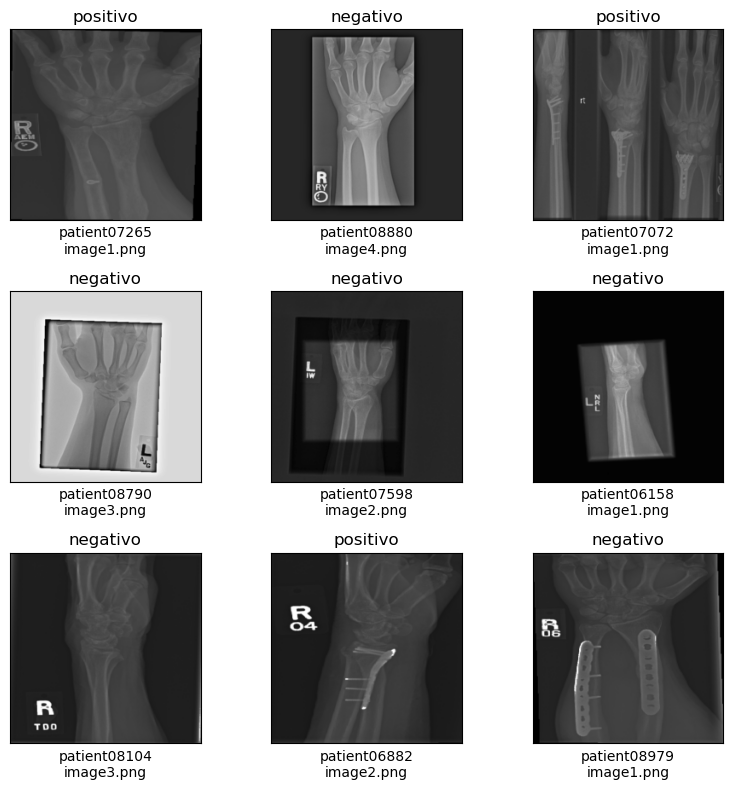

In [18]:
# Hay que utilizar una función para visualizar las imágenes tensoriales
# corrigiendo la normalización y considerando el número de canales
# Aquí simplemente se está corrigiendo utilizando la media y sigma del repositorio

nrows, ncols = 3,3

fig, axs = plt.subplots(ncols=ncols,nrows=nrows,figsize=(8,8))
for r in range(nrows):
    for c in range(ncols):
        sample_idx = torch.randint(len(training_data), size=(1,)).item()

        img, label = training_data[sample_idx]
        patient = re.search(r'\bpatient\d+\b', training_data.img_labels.iloc[sample_idx,0]).group()

        print(img.shape, '\t', img.dtype)
        print('Pixel arbitrario:\t', img[:,10,150])

        axs[r,c].set_title(training_data.labels_map[label])
        axs[r,c].set_xticks([])
        axs[r,c].set_yticks([])
        axs[r,c].set_xlabel(patient+'\n'+
                            os.path.basename(training_data.img_labels.iloc[sample_idx,0]))
       
        axs[r,c].imshow(F.to_pil_image(img*0.0419+0.206), cmap='gray')

plt.tight_layout()

In [19]:
# Los dataloaders se hacen con la clase de Pytorch
# EL dataloader se encarga de ordenar aleatoriamiente las imágenes
# y de agruparlas en "batches" o grupos. La métrica de entrenamiento
# se calcula para las imágenes del batch (gradiente estocástico)
# En cada iteración el dataloader proporciona un "batch" completo
# El batch corresponde a la primera dimensión del tensor: B,C,H,W

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
print('Número de batches de entrenamiento:\t', len(train_dataloader))

test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)
print('Número de batches de test:\t', len(test_dataloader))

Número de batches de entrenamiento:	 153
Número de batches de test:	 11


Batch shape (images): torch.Size([64, 3, 224, 224])
Batch shape (labels): torch.Size([64])


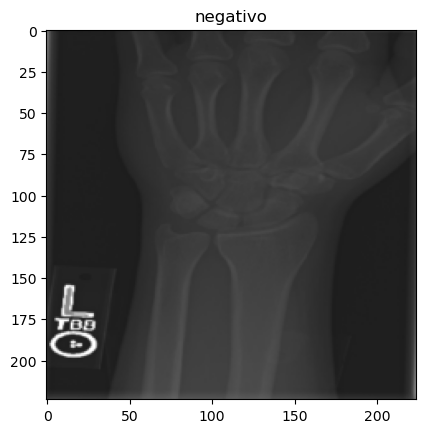

In [20]:
# Visualizamos la 0primera imagen del primer batch
# del conjunto de entrenamiento.
# Cada vez que se vuelva a ejecutar pasa al "batch" siguiente
train_imgs, train_labels = next(iter(train_dataloader))

print(f"Batch shape (images): {train_imgs.size()}")
print(f"Batch shape (labels): {train_labels.size()}")

img = train_imgs[0]
label = train_labels[0]

plt.imshow(F.to_pil_image(img*0.0419+0.206), cmap="gray")
plt.title(training_data.labels_map[label.item()])
plt.show()

In [21]:
# Para continuar con el pipeline hay que recrear los dataloaders
# Pues se han consumido parcialmente al correr antes
# train_imgs, train_labels = next(iter(train_dataloader))

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
print('Número de batches de entrenamiento:\t', len(train_dataloader))

test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)
print('Número de batches de test:\t', len(test_dataloader))

Número de batches de entrenamiento:	 153
Número de batches de test:	 11


In [22]:
device = ('cuda' if torch.cuda.is_available()
  else 'cpu')

print('Using device: ', device)

Using device:  cuda


In [23]:
model = torch.hub.load('pytorch/vision:v0.10.0', model='densenet169', weights='DenseNet169_Weights.DEFAULT')

Using cache found in /home/paula/.cache/torch/hub/pytorch_vision_v0.10.0


In [24]:
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [25]:
model.classifier.out_features = 2

In [26]:
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [51]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model.parameters(), lr = 0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [52]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    model.to(device)
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'test']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                    dataloader = train_dataloader
                else:
                    model.eval()   # Set model to evaluate mode
                    dataloader = test_dataloader
                    
                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()


                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / len (dataloader.dataset)
                epoch_acc = running_corrects.double() / len (dataloader.dataset)

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [53]:
def visualize_model(model, test_dataloader,labels_map,device, num_images=6):
    was_training = model.training
    model.eval()
    model.to(device)
    images_so_far = 0
    fig = plt.figure()

    
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
           
      
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                prob = probs[j, preds[j]].item()
                label_idx = preds[j].item()
                label_name = labels_map[label_idx]
                ax.set_title(f'predicted: {label_name}\nprobability: {prob:.4f}')
                
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)



In [54]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.3833 Acc: 0.8422
test Loss: 0.5257 Acc: 0.7815

Epoch 1/24
----------
train Loss: 0.3327 Acc: 0.8671
test Loss: 0.4666 Acc: 0.7982

Epoch 2/24
----------
train Loss: 0.2943 Acc: 0.8865
test Loss: 0.4618 Acc: 0.8073

Epoch 3/24
----------
train Loss: 0.2623 Acc: 0.9009
test Loss: 0.4845 Acc: 0.7845

Epoch 4/24
----------
train Loss: 0.2290 Acc: 0.9176
test Loss: 0.4600 Acc: 0.7951

Epoch 5/24
----------
train Loss: 0.2030 Acc: 0.9322
test Loss: 0.5036 Acc: 0.8012

Epoch 6/24
----------
train Loss: 0.1798 Acc: 0.9440
test Loss: 0.4966 Acc: 0.7997

Epoch 7/24
----------
train Loss: 0.1523 Acc: 0.9613
test Loss: 0.4721 Acc: 0.7982

Epoch 8/24
----------
train Loss: 0.1494 Acc: 0.9622
test Loss: 0.4733 Acc: 0.7967

Epoch 9/24
----------
train Loss: 0.1520 Acc: 0.9607
test Loss: 0.4734 Acc: 0.7997

Epoch 10/24
----------
train Loss: 0.1454 Acc: 0.9615
test Loss: 0.4889 Acc: 0.8073

Epoch 11/24
----------
train Loss: 0.1463 Acc: 0.9622
test Loss: 0.4748 Acc

In [55]:
labels_map         = {0: 'negativo', 1:'positivo'}

In [56]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated



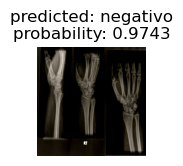

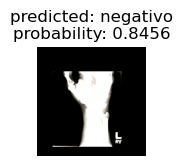

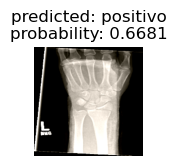

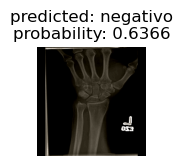

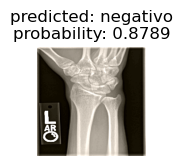

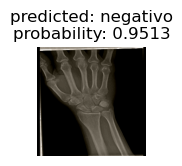

In [57]:
visualize_model(model, test_dataloader, labels_map, device, num_images=6)

In [58]:
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, auc, roc_curve
import matplotlib.pyplot as plt

True Positive: 207
False Positive: 38
True Negative: 326
False Negative: 88
Precision: 0.8448979591836735
Recall: 0.7016949152542373
Accuracy: 0.8088012139605463
AUC: 0.87409200968523


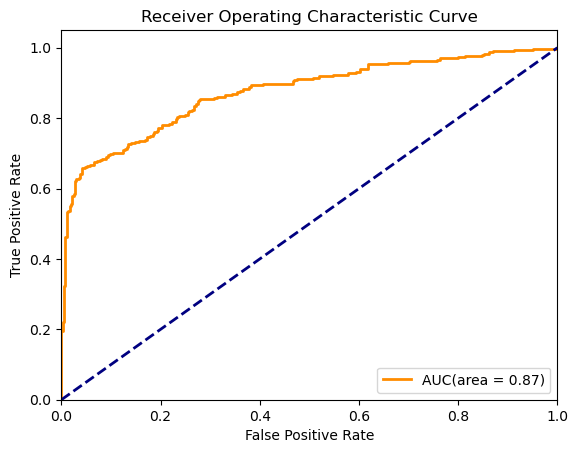

In [59]:
def evaluate_model(model, dataloader, device):
    model.eval()
    tp, fp, tn, fn = 0, 0, 0, 0
    y_true = []
    y_scores = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            tp += ((preds == 1) & (labels == 1)).sum().item()
            fp += ((preds == 1) & (labels == 0)).sum().item()
            tn += ((preds == 0) & (labels == 0)).sum().item()
            fn += ((preds == 0) & (labels == 1)).sum().item()

    
     # Guardar las etiquetas verdaderas y las puntuaciones de predicción para calcular el AUC
            y_true.extend(labels.cpu().numpy())
            y_scores.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    if len(y_true) > 0:  # Verificar si y_true no está vacío
        # Calcular AUC
        y_true = np.array(y_true)
        y_scores = np.array(y_scores)
        fpr, tpr, _ = roc_curve(y_true, y_scores, pos_label=1)  # Especificar pos_label
        roc_auc = auc(fpr, tpr)
    else:
        roc_auc = 0.5  # AUC predeterminado si no hay muestras positivas
    
    print("True Positive:", tp)
    print("False Positive:", fp)
    print("True Negative:", tn)
    print("False Negative:", fn)
    print("Precision:", precision)
    print("Recall:", recall)
    print("Accuracy:", accuracy)
    print("AUC:", roc_auc)

    # Plot ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='AUC(area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()
    

# Ejemplo de uso:
evaluate_model(model, test_dataloader, device)

In [60]:
# Set the model to evaluation mode
model.eval()

# Lists to store true labels and predicted labels
y_true = []
y_pred = []

# Disable gradient computation
with torch.no_grad():
    for test_data in test_dataloader: # Iterate over the test dataloader to get test images and labels
        test_images, test_labels = (test_data[0].to(device), 
                                    test_data[1].to(device))
        # Forward pass through the model to get predictions
        output = model(test_images)
        
        # Compute the predicted labels by taking the argmax of the softmax output
        pred_label = torch.softmax(output, dim = 1).argmax(dim = 1)

        # Append the true labels and predicted labels to their respective lists
        y_true.append(test_labels.cpu())
        y_pred.append(pred_label.cpu())

# Convert the lists of true labels and predicted labels to NumPy arrays
y_true = torch.cat(y_true).numpy()
y_pred = torch.cat(y_pred).numpy()

In [61]:
# Generate the classification report and print it
report = classification_report(y_true, 
                               y_pred, 
                               target_names = ["Positive", "Negative"], 
                               digits = 4)
print(report)

              precision    recall  f1-score   support

    Positive     0.7874    0.8956    0.8380       364
    Negative     0.8449    0.7017    0.7667       295

    accuracy                         0.8088       659
   macro avg     0.8162    0.7986    0.8024       659
weighted avg     0.8132    0.8088    0.8061       659



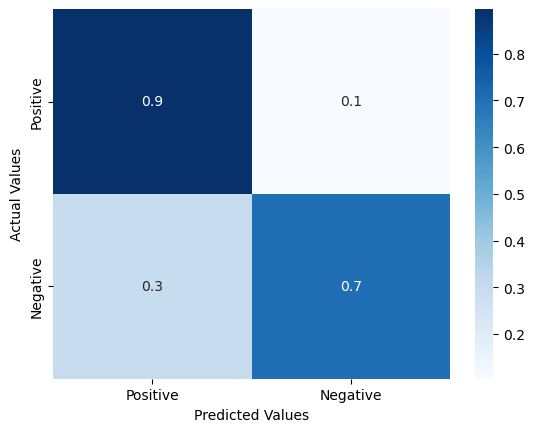

In [62]:
# Generate the confusion matrix
cmat = confusion_matrix(y_true, y_pred, normalize = 'true')

# Create a heatmap for the confusion matrix visualization
ax = sns.heatmap(cmat, annot = True, cmap = 'Blues')

# Set labels for x-axis and y-axis
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')

# Set the labels 
ax.xaxis.set_ticklabels(["Positive","Negative"])
ax.yaxis.set_ticklabels(["Positive","Negative"])

# Display the visualization of the Confusion Matrix
plt.show()